__Note__: The goal is to investigate the drug response of L1000 screening based on the trajectory of cell death cascade. The hypothesis is that cells sensitive to treatment will show more cell death related pathway induction than those who are resistant to the therapy. Therefore, resistant cells are more likely to be at origins, while sensitive cells are more likely to be at branches. The branches might be related to different types of cell death signaling. 

In [1]:
import os
import sys
import umap.umap_ as umap
import pydiffmap

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [60]:
import gc
gc.collect()

20

# Global Path

In [3]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/trajectory/GSEA/'
result_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/trajectory/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure_pending/'

# Data

In [6]:
# extract cell death related GOBP sets
gobp = {}
with open(gsea_home + 'gene_set/c5.go.bp.v2022.1.Hs.symbols.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        if "CELL_DEATH" in lines[0]:
            gobp[lines[0]] = lines[1:]

In [9]:
# write to new .gmt
with open(gsea_home + 'gene_set/GOBP_cell_death_merged.gmt', 'w') as f:
    for k in gobp.keys():
        f.write(k + '\t' + '\t'.join(gobp[k]) + '\n')

In [44]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark.index = bing_landmark.index.astype(str)

In [20]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                       header=0, index_col='sig_id', sep='\t')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
# take MCF7 as case
mcf7_sig = sig_info[sig_info['cell_iname'] == 'MCF7']
mcf7_sig.shape

(110887, 36)

In [27]:
mcf7_sig_24 = mcf7_sig[mcf7_sig['pert_itime'] == '24 h']
mcf_sig_24_htas = mcf7_sig_24[mcf7_sig_24['tas'] >= .4]
mcf_sig_24_htas.shape

(5693, 36)

In [28]:
mcf7_sig_24.shape

(51528, 36)

In [161]:
# take A375 as case
a375_sig = sig_info[sig_info['cell_iname'] == 'A375']
a375_sig_24 = a375_sig[a375_sig['pert_itime'] == '24 h']
a375_sig_24_htas = a375_sig_24[a375_sig_24['tas'] >= .4]
a375_sig_24_htas.shape

(4033, 36)

# 0. Overlap genes from GOBP and BING gene spaces

In [45]:
gobp_merged = []
for k in gobp.keys():
    gobp_merged.extend(gobp[k][1:])
gobp_merged = list(set(gobp_merged))
print(len(gobp_merged))

1724


In [46]:
# overlap
gobp_bing = [g for g in gobp_merged if g in list(bing_landmark['Official NCBI gene symbol'])]
print(len(gobp_bing))

1185


In [231]:
bing_landmark[bing_landmark['Official NCBI gene symbol'].isin(gobp_bing)].to_csv(result_home + 'cell_death_op_bing.csv', sep=',')

In [29]:
# take expression
expr_brca = pd.read_csv(data_home + 'CMAP2020_Cancer/BRCA/CMAP2020_lv5_trt_cp_merged.csv',
                        index_col=0, header=0, sep=',')

In [181]:
expr_brca.index = expr_brca.index.astype(str)
expr_brca_rn = expr_brca.rename(index=bing_landmark['Official NCBI gene symbol'])

In [162]:
# take expression
expr_skcm = pd.read_csv(data_home + 'CMAP2020_Cancer/SKCM/CMAP2020_lv5_trt_cp_merged.csv',
                        index_col=0, header=0, sep=',')

In [182]:
expr_skcm.index = expr_skcm.index.astype(str)
expr_skcm_rn = expr_skcm.rename(index=bing_landmark['Official NCBI gene symbol'])

In [49]:
expr_mcf7 = expr_brca.T[expr_brca.columns.isin(mcf_sig_24_htas.index)].T
expr_mcf7.index = expr_mcf7.index.astype(str)
expr_mcf7 = expr_mcf7.rename(index=bing_landmark['Official NCBI gene symbol'])
expr_mcf7 = expr_mcf7[expr_mcf7.index.isin(gobp_merged)]

In [164]:
expr_a375 = expr_skcm.T[expr_skcm.columns.isin(a375_sig_24_htas.index)].T
expr_a375.index = expr_a375.index.astype(str)
expr_a375 = expr_a375.rename(index=bing_landmark['Official NCBI gene symbol'])
expr_a375 = expr_a375[expr_a375.index.isin(gobp_merged)]

In [50]:
expr_mcf7

,ASG002_MCF7_24H:A07,ASG002_MCF7_24H:A10,ASG002_MCF7_24H:A11,ASG002_MCF7_24H:A13,ASG002_MCF7_24H:A14,ASG002_MCF7_24H:B03,ASG002_MCF7_24H:B04,ASG002_MCF7_24H:B05,ASG002_MCF7_24H:B06,ASG002_MCF7_24H:B07,...,REP.B028_MCF7_24H:K11,REP.B028_MCF7_24H:K12,REP.B028_MCF7_24H:K19,REP.B028_MCF7_24H:K20,REP.B028_MCF7_24H:L07,REP.B028_MCF7_24H:L08,REP.B028_MCF7_24H:O02,REP.B028_MCF7_24H:O04,REP.B028_MCF7_24H:O05,REP.B028_MCF7_24H:O06
rid,,,,,,,,,,,,,,,,,,,,,
ADA,0.095761,-0.431833,0.426748,0.980023,1.261912,-0.379329,-1.023673,-1.675783,-0.604019,0.362065,...,1.33405,2.37630,1.53695,-0.32290,1.14250,0.23350,2.67555,2.77820,0.69010,2.56175
HDAC6,-1.630105,1.660045,0.406322,-0.774096,-0.261448,1.787911,3.040687,2.417449,2.138378,1.380851,...,3.20650,4.66765,1.65860,0.34185,1.66955,2.25410,5.45205,5.55665,2.16120,6.04720
BCL2L10,-0.483532,0.146154,-0.231587,0.167227,-0.004809,0.160520,0.795990,-0.033668,-0.428859,-0.711507,...,0.77065,0.15910,0.03065,0.32005,-0.16790,0.52245,1.31065,-1.13825,0.81125,2.53810
BCL2L11,2.079568,-0.445548,0.238500,2.154811,0.649329,0.609395,0.889732,1.798889,-0.420990,0.301556,...,2.65800,0.57230,-0.64645,-1.18000,-1.35765,-0.68310,1.76575,0.71740,2.33450,1.68545
CDH5,-1.565167,0.406858,0.516008,-0.304817,0.227996,0.702318,0.509946,1.307222,1.396010,0.093550,...,0.02245,-0.16840,-0.23345,-0.16280,0.50765,0.55015,1.00505,-0.36930,1.04750,1.49905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AREL1,-0.045347,-1.330412,-0.452953,-0.108178,0.654652,-0.907525,1.542220,2.309457,1.629644,0.140491,...,1.73870,2.55205,-0.05115,-0.06630,-0.70580,-0.69735,2.27225,2.74190,1.60830,1.86020
MFN2,-0.426290,-2.612472,-1.225985,0.013269,0.095645,-1.421208,0.006028,0.266921,-0.180130,-0.885928,...,2.16720,1.68250,1.63380,1.03005,0.46530,0.56460,1.95670,2.60155,1.61420,1.90535
KIF14,-2.011481,-3.319341,-1.895113,-5.175576,-3.827565,-0.890491,1.630700,1.925550,0.567692,2.107700,...,-10.00000,-9.40690,-6.89910,-5.36115,-5.30140,-4.50805,-8.56175,0.19555,-9.41585,-9.76580


In [165]:
expr_a375

,ABY001_A375_XH:BRD-A61304759:10:24,ABY001_A375_XH:BRD-A61304759:2.5:24,ABY001_A375_XH:BRD-K19687926:10:24,ABY001_A375_XH:BRD-K21680192:0.625:24,ABY001_A375_XH:BRD-K21680192:10:24,ABY001_A375_XH:BRD-K66175015:10:24,ABY001_A375_XH:BRD-K70401845:10:24,ABY001_A375_XH:BRD-K70511574:10:24,ABY001_A375_XH:BRD-K81418486:0.625:24,ABY001_A375_XH:BRD-K81418486:10:24,...,REP.B028_A375_24H:B11,REP.B028_A375_24H:I07,REP.B028_A375_24H:I08,REP.B028_A375_24H:K10,REP.B028_A375_24H:K19,REP.B028_A375_24H:K20,REP.B028_A375_24H:K21,REP.B028_A375_24H:L07,REP.B028_A375_24H:L08,REP.B028_A375_24H:O05
rid,,,,,,,,,,,,,,,,,,,,,
ADA,1.393475,1.990247,0.540987,0.910156,1.040050,0.610513,0.330001,0.943756,-0.461948,1.687490,...,-0.62440,0.19515,0.36935,1.66395,1.86640,2.58605,1.48875,2.07210,1.01770,2.40870
HDAC6,-0.776326,-0.831289,0.017096,-3.640026,0.461481,2.874992,0.071453,2.885610,-1.525007,7.010458,...,-1.71360,-4.38970,-1.70295,0.18505,1.34870,-0.62225,0.57815,-3.63705,-1.18485,1.85270
BCL2L10,0.516278,1.011850,0.905185,1.668256,1.897190,-0.766522,-0.065510,0.683258,-0.134306,1.674573,...,-1.09615,0.41255,0.16195,2.21610,1.53160,1.31870,0.27490,0.24735,-0.45430,3.92600
BCL2L11,0.899055,0.752567,0.913617,1.911168,2.505056,1.247446,-0.702919,1.554625,-0.198212,2.424609,...,0.08435,1.03590,-1.24465,7.44310,2.29540,0.33595,0.67460,-0.46160,-0.73695,7.85770
CDH5,-0.391671,0.737708,0.892956,-0.422004,1.332047,1.070628,-0.418178,0.818211,0.851786,1.061656,...,0.65525,0.82475,-1.71310,3.63815,-0.51085,-0.37155,-1.07650,-0.09785,0.44115,1.58980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AREL1,1.632519,1.503250,-1.585979,0.327386,-1.900946,0.146041,-0.592600,-0.703780,0.610032,1.019429,...,-0.12765,-2.35485,-0.81440,0.17240,-3.40735,-1.88960,-1.89780,-2.78010,-1.51445,0.28755
MFN2,1.203023,0.740489,0.843328,0.287910,-0.844802,-0.839850,0.020165,-0.417439,-0.019018,0.374315,...,1.23875,0.33225,-1.08725,-1.39470,1.25375,0.38275,1.15105,0.10165,0.26795,-5.04510
KIF14,-1.129814,-0.849444,-0.038187,-1.511966,-0.869016,-0.312056,-0.176037,-0.579181,-1.045849,-1.577308,...,0.33790,-10.00000,-6.50615,-8.04770,-8.58125,-9.78535,-7.88120,-9.74235,-5.06285,-9.65185


In [62]:
expr_mcf7.to_csv(result_home + 'cell_death_MCF7_24h_htas_cp.csv', sep=',')

In [166]:
expr_a375.to_csv(result_home + 'cell_death_A375_24h_htas_cp.csv', sep=',')

# 1. Clustering

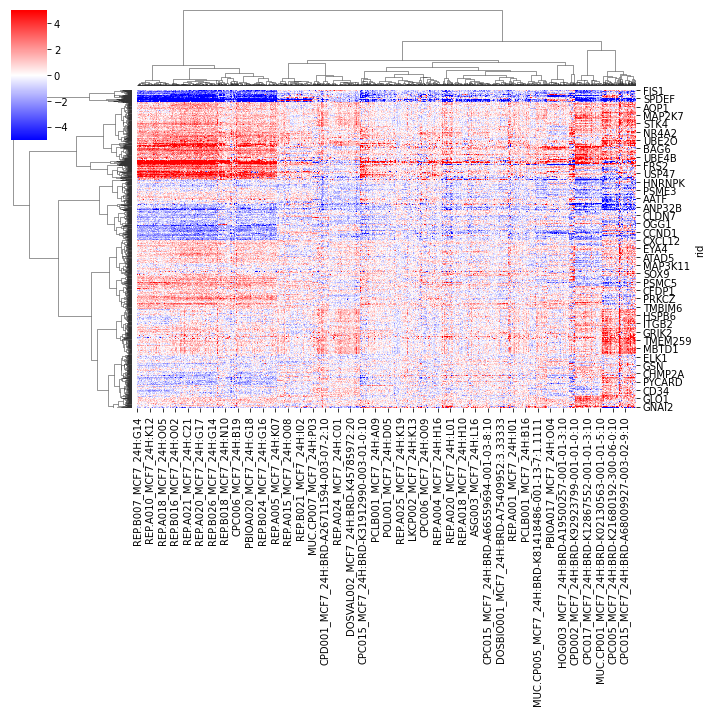

In [57]:
sns.clustermap(expr_mcf7, method='ward', cmap='bwr',
               vmin=-5, vmax=5)

In [183]:
# enrichr on cell death
# pathway enrichment
gobp_nes = df(columns=expr_mcf7.columns)
gobp_fdr = df(columns=expr_mcf7.columns)
for c in expr_mcf7.columns:
    tmp_result = gp.prerank(df(expr_brca_rn[c]).sort_values(by=c, ascending=False),
                            gene_sets=gsea_home + 'gene_set/GOBP_cell_death_merged.gmt',
                            processes=16,
                            permutation_num=1000,
                            outdir=None, seed=0, min_size=10, max_size=200)
    gobp_nes[c] = tmp_result.res2d['nes']
    gobp_fdr[c] = tmp_result.res2d['fdr']

In [184]:
gobp_nes.to_csv(gsea_home + 'MCF7_24h_htas_cell_death_NES.csv', sep=',')
gobp_fdr.to_csv(gsea_home + 'MCF7_24h_htas_cell_death_FDR.csv', sep=',')

In [189]:
# enrichr on cell death
# pathway enrichment
gobp_mito_nes = df(columns=expr_mcf7.columns)
gobp_mito_fdr = df(columns=expr_mcf7.columns)
for c in expr_mcf7.columns:
    tmp_result = gp.prerank(df(expr_brca_rn[c]).sort_values(by=c, ascending=False),
                            gene_sets=gsea_home + 'gene_set/mitophagy_curated.gmt',
                            processes=16,
                            permutation_num=1000,
                            outdir=None, seed=0, min_size=10, max_size=200)
    gobp_mito_nes[c] = tmp_result.res2d['nes']
    gobp_mito_fdr[c] = tmp_result.res2d['fdr']

In [190]:
gobp_mito_nes.to_csv(gsea_home + 'MCF7_24h_htas_mitophagy_NES.csv', sep=',')
gobp_mito_fdr.to_csv(gsea_home + 'MCF7_24h_htas_mitophagy_FDR.csv', sep=',')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


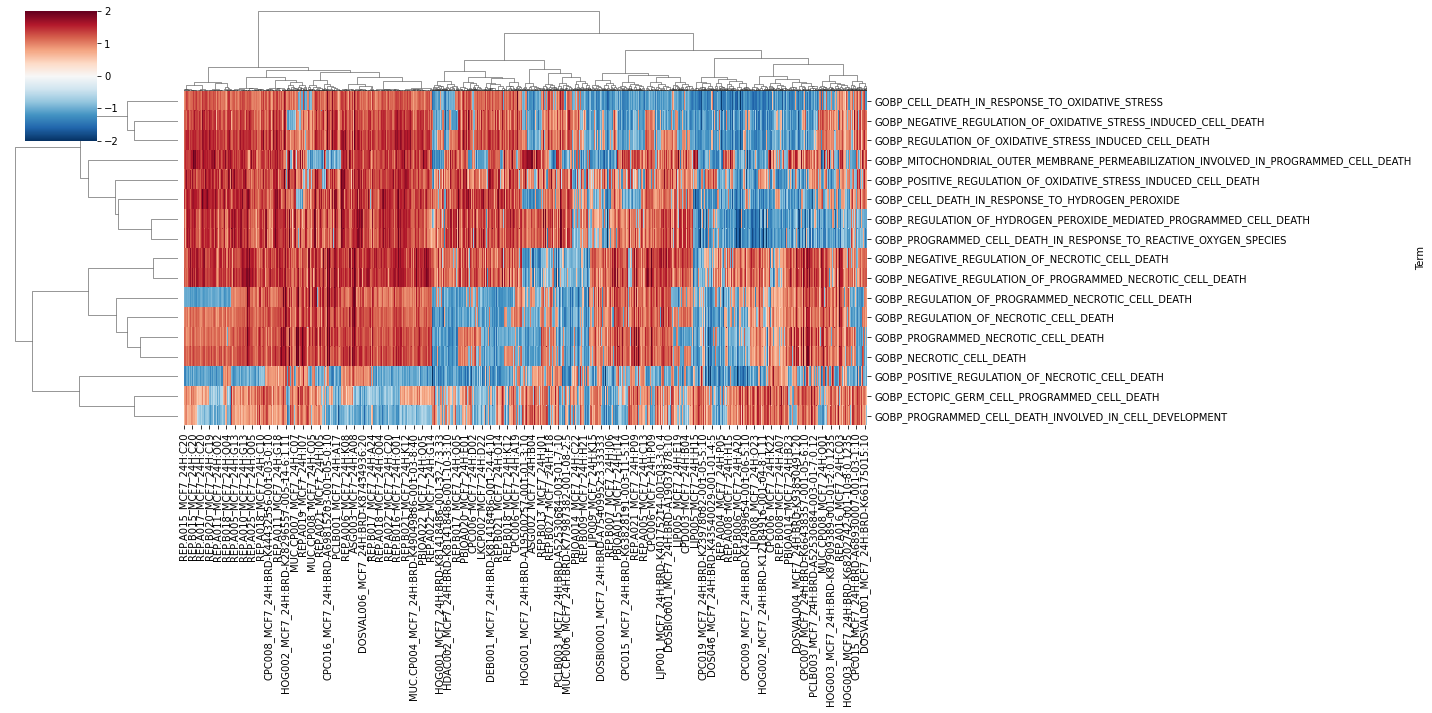

In [185]:
sns.clustermap(gobp_nes, method='ward', cmap='RdBu_r',
               vmin=-2, vmax=2, figsize=(20, 10))

In [186]:
# Tamoxifen
case_tamoxifen = mcf_sig_24_htas[mcf_sig_24_htas['cmap_name'] == 'tamoxifen']

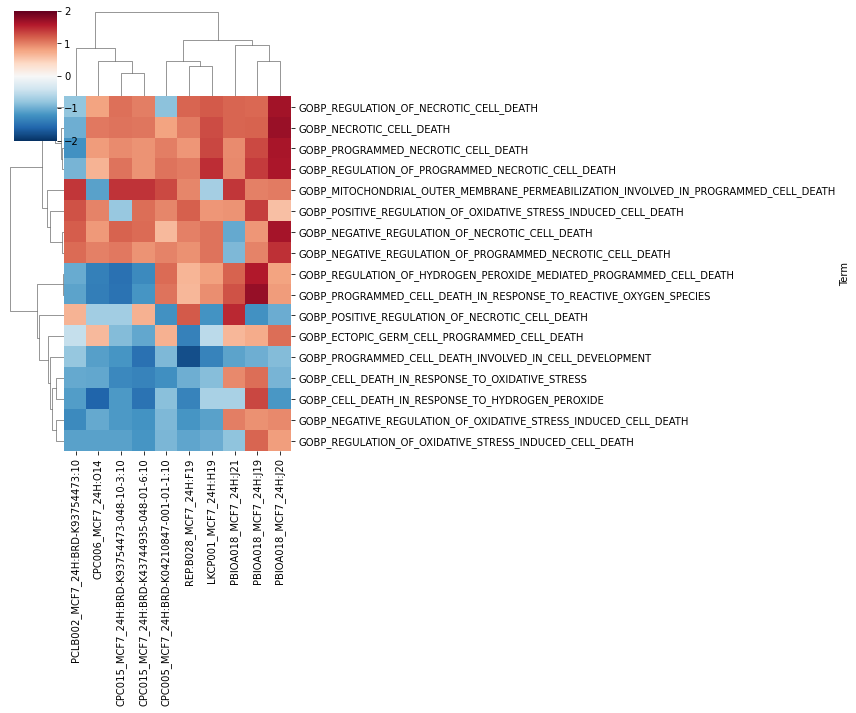

In [187]:
sns.clustermap(gobp_nes[case_tamoxifen.index], method='ward', cmap='RdBu_r',
               vmin=-2, vmax=2, figsize=(12, 10))

In [135]:
case_tamoxifen.sort_values(by='pert_dose')

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
sig_id,,,,,,,,,,,,,,,,,,,,,
PBIOA018_MCF7_24H:J21,b21,1.11,1.11111,uM,1.11 uM,24 h,24.0,h,MCF7,BRD-K93754473,...,MCF7,J21,PBIOA018_MCF7_24H_X1_B21|PBIOA018_MCF7_24H_X2_...,PBIOA018_MCF7_24H_X1_B21:J21|PBIOA018_MCF7_24H...,NaN,PBIOA,tamoxifen,0,1.0,0.0
REP.B028_MCF7_24H:F19,b23,2.22,2.30769,uM,2.22 uM,24 h,24.0,h,MCF7,BRD-K93754473,...,MCF7,F19,REP.B028_MCF7_24H_X1_B23|REP.B028_MCF7_24H_X2_B23,REP.B028_MCF7_24H_X1_B23:F19|REP.B028_MCF7_24H...,NaN,REP,tamoxifen,0,1.0,0.0
PBIOA018_MCF7_24H:J20,b21,3.33,3.33333,uM,3.33 uM,24 h,24.0,h,MCF7,BRD-K93754473,...,MCF7,J20,PBIOA018_MCF7_24H_X1_B21|PBIOA018_MCF7_24H_X2_...,PBIOA018_MCF7_24H_X1_B21:J20|PBIOA018_MCF7_24H...,NaN,PBIOA,tamoxifen,0,1.0,0.0
CPC005_MCF7_24H:BRD-K04210847-001-01-1:10,b4,10.00,10.00000,uM,10 uM,24 h,24.0,h,MCF7,BRD-K04210847,...,MCF7,H10,CPC005_MCF7_24H_X1_B4_DUO52HI53LO|CPC005_MCF7_...,CPC005_MCF7_24H_X1_B4_DUO52HI53LO:H10|CPC005_M...,NaN,CPC,tamoxifen,1,1.0,0.0
CPC015_MCF7_24H:BRD-K93754473-048-10-3:10,b4,10.00,10.00000,uM,10 uM,24 h,24.0,h,MCF7,BRD-K93754473,...,MCF7,F20,CPC015_MCF7_24H_X1_B4_DUO52HI53LO|CPC015_MCF7_...,CPC015_MCF7_24H_X1_B4_DUO52HI53LO:F20|CPC015_M...,NaN,CPC,tamoxifen,0,1.0,0.0
CPC015_MCF7_24H:BRD-K43744935-048-01-6:10,b4,10.00,10.00000,uM,10 uM,24 h,24.0,h,MCF7,BRD-K43744935,...,MCF7,O03,CPC015_MCF7_24H_X1_B4_DUO52HI53LO|CPC015_MCF7_...,CPC015_MCF7_24H_X1_B4_DUO52HI53LO:O03|CPC015_M...,NaN,CPC,tamoxifen,1,1.0,0.0
LKCP001_MCF7_24H:H19,b41,10.00,10.00000,uM,10 uM,24 h,24.0,h,MCF7,BRD-K93754473,...,MCF7,H19,LKCP001_MCF7_24H_X1_B41|LKCP001_MCF7_24H_X3.A2...,LKCP001_MCF7_24H_X1_B41:H19|LKCP001_MCF7_24H_X...,NaN,LKCP,tamoxifen,0,1.0,0.0
PCLB002_MCF7_24H:BRD-K93754473:10,b13,10.00,10.00000,uM,10 uM,24 h,24.0,h,MCF7,BRD-K93754473,...,MCF7,B13|D13,PCLB002_MCF7_24H_X1_B13|PCLB002_MCF7_24H_X2_B1...,PCLB002_MCF7_24H_X1_B13:B13|PCLB002_MCF7_24H_X...,NaN,PCLB,tamoxifen,0,1.0,0.0
PBIOA018_MCF7_24H:J19,b21,10.00,10.00000,uM,10 uM,24 h,24.0,h,MCF7,BRD-K93754473,...,MCF7,J19,PBIOA018_MCF7_24H_X1_B21|PBIOA018_MCF7_24H_X2_...,PBIOA018_MCF7_24H_X1_B21:J19|PBIOA018_MCF7_24H...,NaN,PBIOA,tamoxifen,1,1.0,0.0


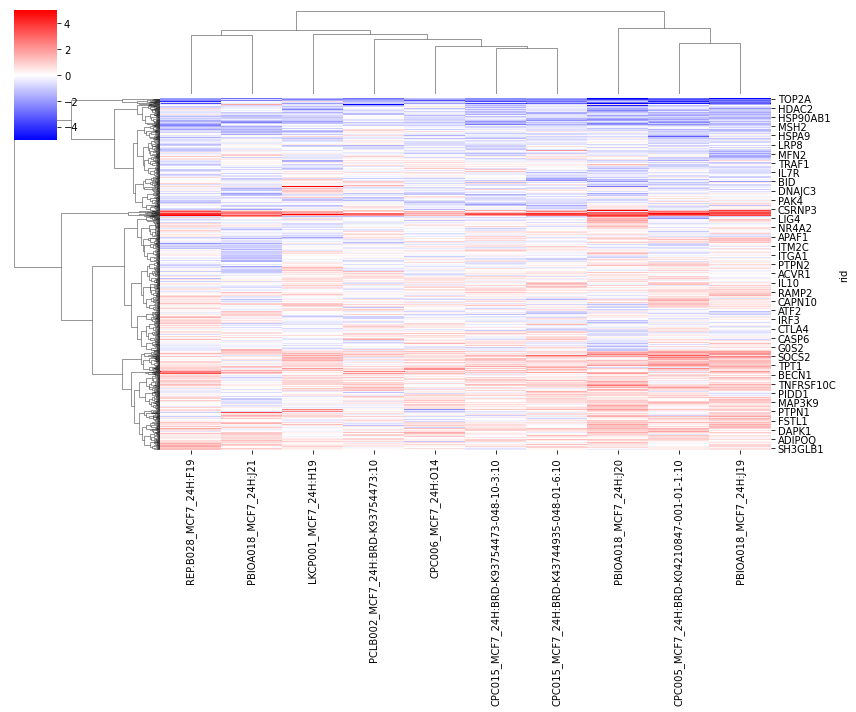

In [137]:
sns.clustermap(expr_mcf7[case_tamoxifen.index], method='ward', cmap='bwr',
               vmin=-5, vmax=5, figsize=(12, 10))

# 2. Trajectory by PCA

In [80]:
pca_fit = PCA(n_components=15, random_state=0)
pca_coord = df(pca_fit.fit_transform(expr_mcf7.T), columns=['pc' + str(i) for i in range(15)], index=expr_mcf7.columns)

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

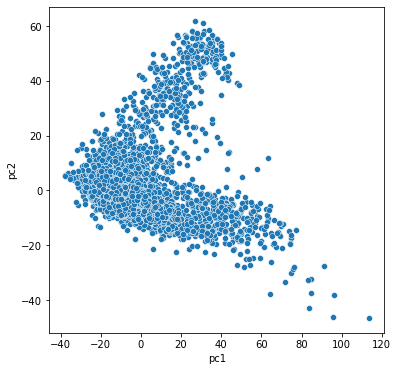

In [86]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pc1', y='pc2', data=pca_coord)

In [141]:
pca_coord_markers = pca_coord[['pc1', 'pc2']]
pca_coord_markers['CD34'] = expr_mcf7.T['CD34']
pca_coord_markers['BAG6'] = expr_mcf7.T['BAG6']

<ipython-input-141-8ee0de13ca6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_coord_markers['CD34'] = expr_mcf7.T['CD34']
<ipython-input-141-8ee0de13ca6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_coord_markers['BAG6'] = expr_mcf7.T['BAG6']


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

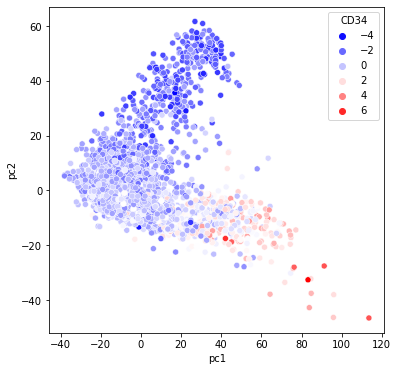

In [111]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pc1', y='pc2', hue='CD34', data=pca_coord_markers, palette='bwr')

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

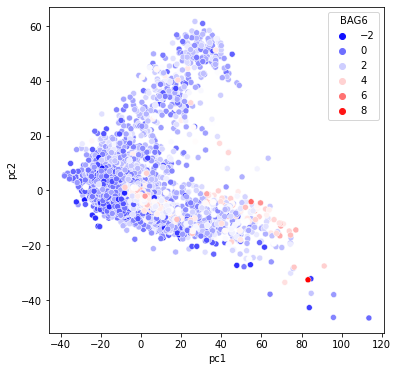

In [144]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pc1', y='pc2', hue='BAG6', data=pca_coord_markers, palette='bwr')

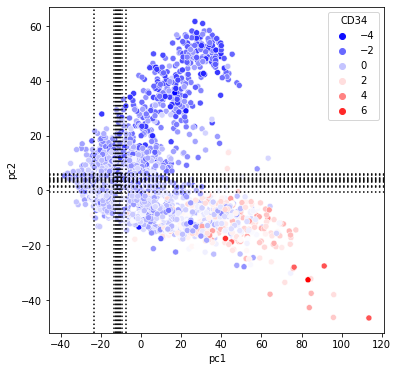

In [139]:
# locate tamoxifen
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pc1', y='pc2', hue='CD34', data=pca_coord_markers, palette='bwr')
for c in case_tamoxifen.index:
    plt.axvline(x=pca_coord_markers.loc[c, 'pc1'], ls=':', c='k')
    plt.axhline(y=pca_coord_markers.loc[c, 'pc2'], ls=':', c='k')

## 2.1 assign shift ability

In [112]:
# all shift ability
tmp_shift = []
for c in os.listdir(poseidon_home + 'shift_ability/'):
    # take only compound treatment
    if c.split('.csv')[0].split('_')[-1] == 'cp':
        tmp_shift.append(pd.read_csv(poseidon_home + 'shift_ability/' + c,
                                     index_col=0, header=0, sep=','))
shift_ability = pd.concat(tmp_shift, axis=0)

In [113]:
pca_coord_markers['shift_ability'] = shift_ability['shift_ability']

<ipython-input-113-75786b719a22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_coord_markers['shift_ability'] = shift_ability['shift_ability']


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

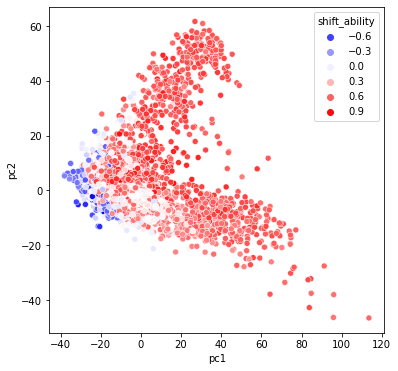

In [114]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pc1', y='pc2', hue='shift_ability', data=pca_coord_markers, palette='bwr')

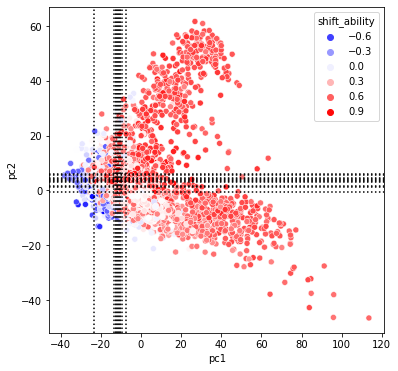

In [140]:
# locate tamoxifen
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pc1', y='pc2', hue='shift_ability', data=pca_coord_markers, palette='bwr')
for c in case_tamoxifen.index:
    plt.axvline(x=pca_coord_markers.loc[c, 'pc1'], ls=':', c='k')
    plt.axhline(y=pca_coord_markers.loc[c, 'pc2'], ls=':', c='k')

# 3. Cell death score

In [146]:
cds = df(expr_mcf7.mean(axis=0)).rename(columns={0: 'cell_death_ave'})
cds

,cell_death_ave
ASG002_MCF7_24H:A07,0.151086
ASG002_MCF7_24H:A10,0.165160
ASG002_MCF7_24H:A11,0.062638
ASG002_MCF7_24H:A13,0.205335
ASG002_MCF7_24H:A14,0.072492
...,...
REP.B028_MCF7_24H:L08,-0.078466
REP.B028_MCF7_24H:O02,0.432763
REP.B028_MCF7_24H:O04,0.272991
REP.B028_MCF7_24H:O05,0.584838


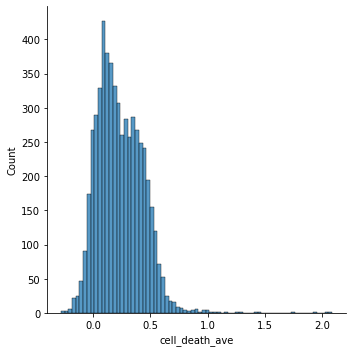

In [178]:
sns.displot(cds['cell_death_ave'])

In [191]:
gobp_mito_nes

,ASG002_MCF7_24H:A07,ASG002_MCF7_24H:A10,ASG002_MCF7_24H:A11,ASG002_MCF7_24H:A13,ASG002_MCF7_24H:A14,ASG002_MCF7_24H:B03,ASG002_MCF7_24H:B04,ASG002_MCF7_24H:B05,ASG002_MCF7_24H:B06,ASG002_MCF7_24H:B07,...,REP.B028_MCF7_24H:K11,REP.B028_MCF7_24H:K12,REP.B028_MCF7_24H:K19,REP.B028_MCF7_24H:K20,REP.B028_MCF7_24H:L07,REP.B028_MCF7_24H:L08,REP.B028_MCF7_24H:O02,REP.B028_MCF7_24H:O04,REP.B028_MCF7_24H:O05,REP.B028_MCF7_24H:O06
Term,,,,,,,,,,,,,,,,,,,,,
GOBP_REGULATION_OF_MITOPHAGY,-1.489292,0.908914,-1.243641,1.195309,1.537890,-0.989594,1.675799,1.181809,1.374362,-0.673276,...,-1.608341,-1.568396,1.998763,2.014750,2.154754,2.175767,-1.769829,-1.407987,-1.545184,-2.279253
GOBP_AUTOPHAGY_OF_MITOCHONDRION,1.319673,1.158340,1.230689,2.323947,2.278047,-1.539263,2.095920,2.192463,2.130281,-0.981912,...,1.701955,1.664139,1.688531,1.888084,2.045310,2.229036,1.775768,2.008452,1.235070,1.124955
GOBP_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION,-1.056415,-0.998597,-1.146334,1.942623,2.179879,-1.702781,1.556427,1.478139,1.538525,1.201899,...,1.244229,1.327189,2.051648,1.946188,2.008881,2.492276,1.443703,1.559537,0.883780,1.097661
GOBP_MITOPHAGY,1.040355,1.532520,1.122821,1.861187,1.955921,1.066169,2.320255,2.107289,1.943729,-0.877500,...,1.250517,1.484393,2.130907,2.430599,2.190708,2.281284,1.370512,1.574140,0.771099,1.138715
GOBP_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION_IN_RESPONSE_TO_MITOCHONDRIAL_DEPOLARIZATION,-1.068492,1.007986,1.419096,1.151013,1.783209,0.983896,1.944238,1.557689,1.582749,-1.157317,...,1.230362,1.168802,1.930045,1.952485,1.965646,1.784821,1.329551,1.914551,0.922106,1.212195


In [192]:
cds['shift_ability'] = shift_ability['shift_ability']
cds['cmap_name'] = mcf7_sig['cmap_name']
cds['pert_dose'] = mcf7_sig['pert_dose']
cds['mitophagy'] = gobp_mito_nes.T['GOBP_AUTOPHAGY_OF_MITOCHONDRION']

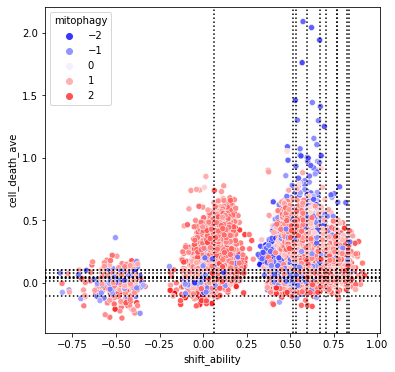

In [194]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='shift_ability', y='cell_death_ave', hue='mitophagy', data=cds, palette='bwr')
for c in case_tamoxifen.index:
    plt.axvline(x=cds.loc[c, 'shift_ability'], ls=':', c='k')
    plt.axhline(y=cds.loc[c, 'cell_death_ave'], ls=':', c='k')

<AxesSubplot:xlabel='shift_ability', ylabel='cell_death_ave'>

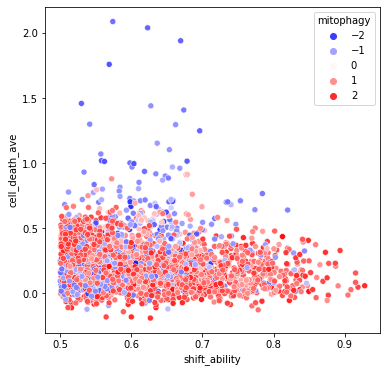

In [196]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='shift_ability', y='cell_death_ave', hue='mitophagy',
                palette='bwr',
                data=cds[cds['shift_ability'] >= .5])

<AxesSubplot:xlabel='shift_ability', ylabel='cell_death_ave'>

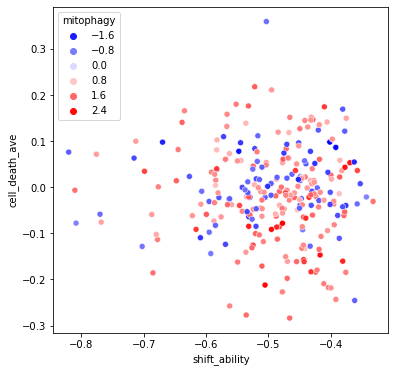

In [198]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='shift_ability', y='cell_death_ave', hue='mitophagy',
                palette='bwr',
                data=cds[cds['shift_ability'] <= -.25])

<AxesSubplot:xlabel='mitophagy', ylabel='shift_ability'>

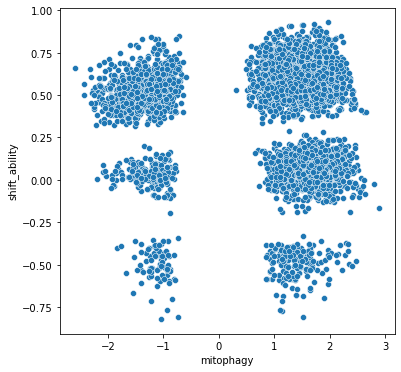

In [203]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='mitophagy', y='shift_ability',
                data=cds[cds['cell_death_ave'] <= .5])

In [153]:
cds.sort_values(by='cell_death_ave', ascending=False)

,cell_death_ave,shift_ability,cmap_name
REP.A011_MCF7_24H:J05,2.088130,0.573888,tizanidine
REP.A011_MCF7_24H:E01,2.040064,0.622852,PD-184352
REP.A011_MCF7_24H:A24,1.940473,0.669277,nepafenac
ASG003_MCF7_24H:O22,1.759364,0.568846,ceritinib
ASG003_MCF7_24H:O23,1.458924,0.529728,ceritinib
...,...,...,...
CPC013_MCF7_24H:BRD-K64440589-001-01-3:10,-0.243311,-0.392023,SEW-05685
MUC.CP001_MCF7_24H:BRD-K03073795-001-01-6:9.9967,-0.245615,-0.361863,SA-1938756
HOG001_MCF7_24H:BRD-K06854232-001-03-3:0.0412,-0.257498,-0.562151,AM-580
CPC013_MCF7_24H:BRD-K66763349-001-01-7:10,-0.277165,-0.535624,STOCK1S-03920


<AxesSubplot:xlabel='pert_dose', ylabel='cell_death_ave'>

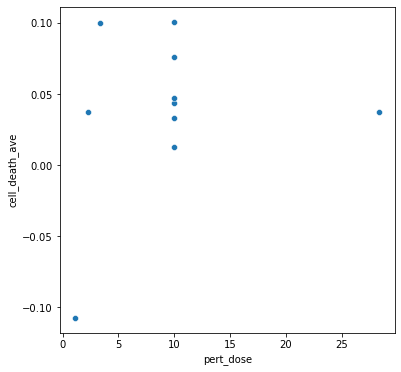

In [157]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pert_dose', y='cell_death_ave', data=cds[cds.index.isin(case_tamoxifen.index)])

<AxesSubplot:xlabel='pert_dose', ylabel='cell_death_ave'>

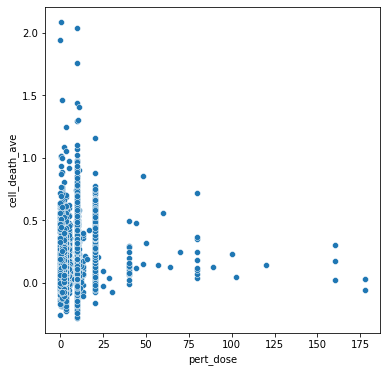

In [158]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pert_dose', y='cell_death_ave', data=cds)

In [176]:
pca_coord_markers['cds'] = cds['cell_death_ave']

<ipython-input-176-95d5780aa24e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_coord_markers['cds'] = cds['cell_death_ave']


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

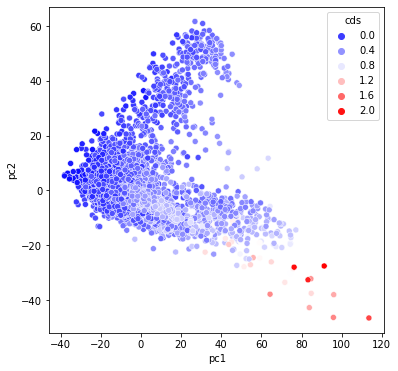

In [177]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='pc1', y='pc2', hue='cds', data=pca_coord_markers, palette='bwr')

# 4. CDS in A375

In [168]:
cds_a375 = df(expr_a375.mean(axis=0)).rename(columns={0: 'cell_death_ave'})
cds_a375

,cell_death_ave
ABY001_A375_XH:BRD-A61304759:10:24,0.157144
ABY001_A375_XH:BRD-A61304759:2.5:24,0.220405
ABY001_A375_XH:BRD-K19687926:10:24,0.174384
ABY001_A375_XH:BRD-K21680192:0.625:24,0.418623
ABY001_A375_XH:BRD-K21680192:10:24,0.458225
...,...
REP.B028_A375_24H:K20,0.111024
REP.B028_A375_24H:K21,0.015868
REP.B028_A375_24H:L07,0.122804
REP.B028_A375_24H:L08,0.030105


In [169]:
cds_a375['shift_ability'] = shift_ability['shift_ability']
cds_a375['cmap_name'] = a375_sig['cmap_name']
cds_a375['pert_dose'] = a375_sig['pert_dose']

In [170]:
case_pak4 = a375_sig_24_htas[a375_sig_24_htas['cmap_name'] == 'PF-03758309']

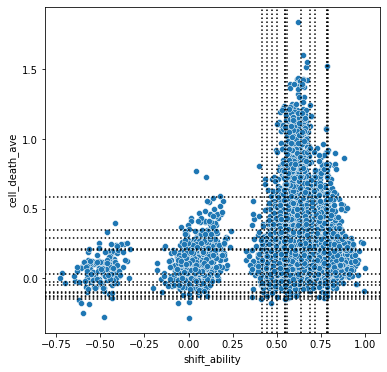

In [171]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='shift_ability', y='cell_death_ave', data=cds_a375)
for c in case_pak4.index:
    plt.axvline(x=cds_a375.loc[c, 'shift_ability'], ls=':', c='k')
    plt.axhline(y=cds_a375.loc[c, 'cell_death_ave'], ls=':', c='k')

<AxesSubplot:xlabel='shift_ability', ylabel='cell_death_ave'>

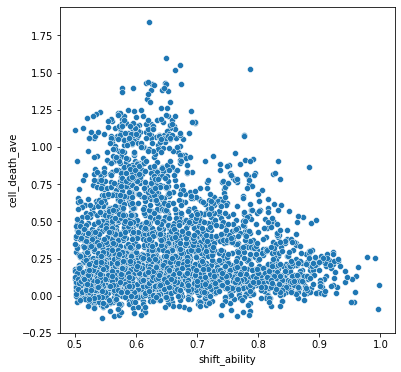

In [174]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='shift_ability', y='cell_death_ave', data=cds_a375[cds_a375['shift_ability'] >= .5])

In [204]:
# enrichr on cell death
# pathway enrichment
a375_mito_nes = df(columns=expr_a375.columns)
a375_mito_fdr = df(columns=expr_a375.columns)
for c in expr_a375.columns:
    tmp_result = gp.prerank(df(expr_skcm_rn[c]).sort_values(by=c, ascending=False),
                            gene_sets=gsea_home + 'gene_set/mitophagy_curated.gmt',
                            processes=16,
                            permutation_num=1000,
                            outdir=None, seed=0, min_size=10, max_size=200)
    a375_mito_nes[c] = tmp_result.res2d['nes']
    a375_mito_fdr[c] = tmp_result.res2d['fdr']

In [205]:
a375_mito_nes.to_csv(gsea_home + 'A375_24h_htas_mitophagy_NES.csv', sep=',')
a375_mito_fdr.to_csv(gsea_home + 'A375_24h_htas_mitophagy_FDR.csv', sep=',')

In [206]:
cds_a375['mitophagy'] = a375_mito_nes.T['GOBP_AUTOPHAGY_OF_MITOCHONDRION']

<AxesSubplot:xlabel='shift_ability', ylabel='cell_death_ave'>

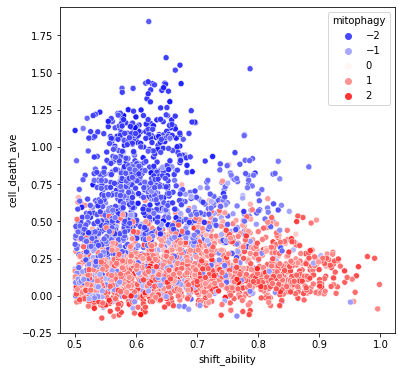

In [209]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='shift_ability', y='cell_death_ave', hue='mitophagy',
                palette='bwr',
                data=cds_a375[cds_a375['shift_ability'] >= .5])

<AxesSubplot:xlabel='mitophagy', ylabel='cell_death_ave'>

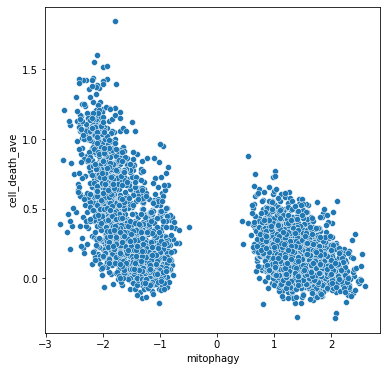

In [223]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='mitophagy', y='cell_death_ave',
                palette='bwr',
                data=cds_a375)

In [225]:
stats.spearmanr(cds_a375['mitophagy'], cds_a375['cell_death_ave'])

SpearmanrResult(correlation=-0.557963417618644, pvalue=0.0)

<AxesSubplot:xlabel='mitophagy', ylabel='cell_death_ave'>

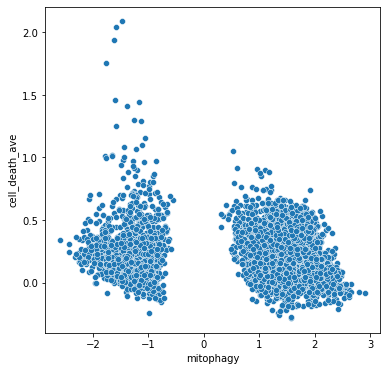

In [224]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='mitophagy', y='cell_death_ave',
                palette='bwr',
                data=cds)

In [228]:
stats.spearmanr(cds['mitophagy'], cds['cell_death_ave'])

SpearmanrResult(correlation=-0.04248401561257438, pvalue=0.0014430546432570516)

# 4. PAK4 inhibitor

In [214]:
cds[cds['cmap_name'] == 'PF-03758309'].sort_values(by='pert_dose')

,cell_death_ave,shift_ability,cmap_name,pert_dose,mitophagy
REP.A014_MCF7_24H:K18,-0.174306,0.403779,PF-03758309,0.041152,1.879504
REP.B014_MCF7_24H:K16,0.106818,0.573726,PF-03758309,0.085470,1.421857
REP.A014_MCF7_24H:K17,0.039844,0.790873,PF-03758309,0.123457,1.239450
REP.A014_MCF7_24H:K16,-0.000429,0.056569,PF-03758309,0.370370,1.885059
REP.B014_MCF7_24H:K14,0.028214,0.089336,PF-03758309,0.769231,1.921210
REP.A014_MCF7_24H:K15,0.046655,0.649409,PF-03758309,1.111110,1.717132
REP.B014_MCF7_24H:K13,0.079963,0.575058,PF-03758309,2.307690,1.379016
LJP009_MCF7_24H:D02,0.067263,0.424646,PF-03758309,3.330000,1.814676
REP.A014_MCF7_24H:K14,-0.049594,0.018224,PF-03758309,3.333330,1.685803
REP.A014_MCF7_24H:K13,0.441792,0.571729,PF-03758309,10.000000,-0.829959


In [215]:
cds_a375[cds_a375['cmap_name'] == 'PF-03758309'].sort_values(by='pert_dose')

,cell_death_ave,shift_ability,cmap_name,pert_dose,mitophagy
REP.A014_A375_24H:K17,-0.128385,0.441845,PF-03758309,0.123457,1.146412
REP.B014_A375_24H:K15,-0.132598,0.499144,PF-03758309,0.256410,1.378734
REP.A014_A375_24H:K16,-0.150362,0.544226,PF-03758309,0.370370,1.626613
REP.B014_A375_24H:K14,0.292447,0.546903,PF-03758309,0.769231,-1.313482
LJP009_A375_24H:D03,0.208956,0.470238,PF-03758309,1.110000,-1.091400
MOAR004_A375_24H:A18,-0.048775,0.786408,PF-03758309,1.111110,1.498056
REP.A014_A375_24H:K15,0.034775,0.415346,PF-03758309,1.111110,1.427865
REP.B014_A375_24H:K13,-0.104480,0.557943,PF-03758309,2.307690,1.809472
LJP009_A375_24H:D02,0.344994,0.792535,PF-03758309,3.330000,-0.664328
MOAR004_A375_24H:A17,-0.100242,0.786920,PF-03758309,3.333330,1.737210


# 5. Selumetinib

In [216]:
cds[cds['cmap_name'] == 'selumetinib'].sort_values(by='pert_dose')

,cell_death_ave,shift_ability,cmap_name,pert_dose,mitophagy


In [217]:
cds_a375[cds_a375['cmap_name'] == 'selumetinib'].sort_values(by='pert_dose')

,cell_death_ave,shift_ability,cmap_name,pert_dose,mitophagy
REP.A015_A375_24H:E24,0.013331,0.861241,selumetinib,0.041152,1.387382
PBIOA019_A375_24H:D12,0.069319,0.856655,selumetinib,0.041152,1.285099
LJP006_A375_24H:M11,0.006947,0.786161,selumetinib,0.120000,1.304276
PBIOA019_A375_24H:D11,0.204868,0.755641,selumetinib,0.123457,0.878822
REP.A015_A375_24H:E23,0.093330,0.865419,selumetinib,0.123457,1.253733
LJP006_A375_24H:M10,0.014764,0.874276,selumetinib,0.370000,1.633605
REP.A015_A375_24H:E22,-0.032557,0.838522,selumetinib,0.370370,1.566681
PBIOA019_A375_24H:D10,0.236773,0.800122,selumetinib,0.370370,-0.857594
REP.A015_A375_24H:E21,0.048994,0.848812,selumetinib,1.111110,1.313091
PBIOA019_A375_24H:D09,0.289356,0.822781,selumetinib,1.111110,1.248163


In [218]:
cds[cds['cmap_name'] == 'gemcitabine'].sort_values(by='pert_dose')

,cell_death_ave,shift_ability,cmap_name,pert_dose,mitophagy
REP.B010_MCF7_24H:N18,0.057667,0.649010,gemcitabine,0.009497,1.426250
REP.B010_MCF7_24H:N17,-0.014780,0.876901,gemcitabine,0.028490,1.747819
REP.A010_MCF7_24H:N18,0.017760,0.646951,gemcitabine,0.041152,1.270973
PBIOA014_MCF7_24H:B18,0.321356,0.711105,gemcitabine,0.041152,-1.290893
CPC006_MCF7_24H:P01,-0.031033,0.829455,gemcitabine,0.080000,1.529404
REP.B010_MCF7_24H:N16,0.017437,0.735176,gemcitabine,0.085470,1.500643
PBIOA014_MCF7_24H:B17,0.237402,0.669655,gemcitabine,0.123457,0.769931
REP.A010_MCF7_24H:N17,-0.127299,0.778292,gemcitabine,0.123457,1.299852
REP.B010_MCF7_24H:N15,-0.028682,0.636999,gemcitabine,0.256410,1.459833
PBIOA014_MCF7_24H:B16,0.097906,0.679340,gemcitabine,0.370370,1.331296


In [219]:
cds_a375[cds_a375['cmap_name'] == 'gemcitabine'].sort_values(by='pert_dose')

,cell_death_ave,shift_ability,cmap_name,pert_dose,mitophagy
PBIOA014_A375_24H:B18,0.128652,0.738731,gemcitabine,0.041152,-1.351392
REP.A010_A375_24H:N18,0.026342,0.597623,gemcitabine,0.041152,1.352291
CPC006_A375_24H:BRD-K15108141-001-01-7:0.08,0.249587,0.651145,gemcitabine,0.080000,-1.305574
PBIOA014_A375_24H:B17,0.095908,0.541904,gemcitabine,0.123457,1.115680
REP.A010_A375_24H:N17,0.104509,0.620318,gemcitabine,0.123457,-1.125796
PBIOA014_A375_24H:B16,0.251367,0.631347,gemcitabine,0.370370,-1.273034
REP.A010_A375_24H:N16,0.069866,0.509731,gemcitabine,0.370370,1.133128
MOAR005_A375_24H:P09,0.276170,0.687376,gemcitabine,1.111110,0.944899
PBIOA014_A375_24H:B15,0.041703,0.608436,gemcitabine,1.111110,-1.197223
REP.A010_A375_24H:N15,0.143590,0.564713,gemcitabine,1.111110,1.008004
